# setup

In [1]:
import aiohttp
import json
import os

import matplotlib.pyplot as plt
import nest_asyncio
from tqdm.notebook import tqdm

## change these parameters

In [24]:
NUM_KIDS = 100 # per story

# Generate a unique filename for this run
HN_STORIES_JSON = '../sampled_hn_stories_dataset.json' # contains the raw fetched hn stories and comment ids
HN_STORIES_CSV = '../sampled_hn_stories_dataset.csv' # after converting raw json to raw csv
KEYWORDS_TXT = '../ai_keywords.txt' # used to match relevant hn stories titles
HN_GITHUB_URLS_TXT = 'hn_github_urls.txt'

# Define the base URL for the Hacker News API
BASE_URL = 'https://hacker-news.firebaseio.com/v0'

CHATGPT_RELEASE_ID = 33804874 # just for reference
START_ID = 31300000 # may 8th 2022
END_ID = 40300000 # may 9th 2024
INCREMENT = 10
DEPTH = 3 # comments depth

In [3]:
# setup async
nest_asyncio.apply()

In [4]:
# test that calling hackernews api works
async with aiohttp.ClientSession() as session:
    async with session.get(f'{BASE_URL}/topstories.json') as response:
        print(await response.json())

[41423577, 41422311, 41423303, 41420597, 41422126, 41421846, 41421650, 41422796, 41422849, 41418301, 41423227, 41398092, 41422378, 41422387, 41397897, 41401664, 41422283, 41417263, 41415650, 41421325, 41384590, 41423231, 41400639, 41417997, 41415023, 41417659, 41415651, 41416714, 41415634, 41415866, 41388750, 41417482, 41422559, 41412256, 41421591, 41420681, 41419645, 41415841, 41421627, 41417024, 41415286, 41383937, 41420744, 41415647, 41398629, 41404383, 41409157, 41418943, 41401941, 41396015, 41415238, 41384456, 41417109, 41419354, 41380686, 41405424, 41422235, 41415207, 41413662, 41415077, 41418153, 41420112, 41423115, 41409503, 41421018, 41400504, 41423473, 41416644, 41417951, 41417458, 41406550, 41420958, 41409882, 41415800, 41397625, 41418367, 41386319, 41422498, 41418464, 41398633, 41398010, 41400475, 41415187, 41404064, 41421520, 41403431, 41408772, 41412221, 41411122, 41409434, 41397498, 41381920, 41399872, 41416845, 41407195, 41404117, 41422081, 41408738, 41410442, 41417556,

# fetch and structure the dataset

In [5]:
# retrieve keywords from ai_keywords.txt
keywords = []
with open(KEYWORDS_TXT, 'r') as f:
    keywords = [keyword.strip() for keyword in f.readlines()]
    print(keywords)

['Artificial Intelligence', 'AI', 'Natural Language Processing', 'NLP', 'Language Model', 'LLM', 'Chatbot', 'ChatGPT', 'OpenAI', 'Claude', 'Llama', 'Gemini', 'Gemma', 'Mistral', 'Cohere']


## hackernews methods setup

In [6]:
import re

async def get_top_story_ids(session):
    async with session.get(f'{BASE_URL}/topstories.json') as response:
        return await response.json()

async def get_item(session, item_id):
    async with session.get(f'{BASE_URL}/item/{item_id}.json') as response:
        return await response.json()

def load_progress(filename):
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            return json.load(f)
    return {'processed_story_max_id': -1, 'stories': []}

def save_progress(data, filename):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

async def search_stories(progress_filename, start_id, end_id):
    progress = load_progress(progress_filename)
    progress_story_max_id = progress['processed_story_max_id']
    stories = progress['stories']
    # print('max id: ', progress_story_max_id)

    async with aiohttp.ClientSession() as session:

        if progress_story_max_id < 0:
            # Starting from the specified story id until we reached the required quantity
            story_id = start_id
        else:
            # otherwise, start from the last processed story
            story_id = progress_story_max_id

        pbar = tqdm(total=end_id-start_id, desc="Fetching stories")
        pbar.update(story_id-start_id)

        # print('current id: ', story_id)
        # main loop
        increment = INCREMENT
        while story_id < end_id:
            try:
                # check whether we already retrieved title
                if story_id <= progress_story_max_id:
                    story_id += increment
                    pbar.update(increment)
                    continue

                # get story
                story = await get_item(session, story_id)

                # check whether story exists, if not then skip next time
                if not story or 'title' not in story:
                    story_id += increment
                    progress_story_max_id = story_id
                    pbar.update(increment)
                    continue

                # Minimum score of 20 to ensure that there's enough discussions going on
                if story['score'] < 20:
                    story_id += increment
                    progress_story_max_id = story_id
                    pbar.update(increment)
                    continue

                # check if the story title contains keyword
                title_lower = story['title'].lower()
                for keyword in keywords:
                    pattern = r'\b' + re.escape(keyword.lower()) + r'\b'

                    if re.search(pattern, title_lower):
                        # check if contains kids
                        # story['kids_texts'] = await get_kids_text(session, story)

                        # add to stories
                        stories.append(story)
                        break
                story_id += increment
                progress_story_max_id = story_id
                pbar.update(increment)

                # save progress periodically
                # if len(stories) % 10 or len(processed_stories) % 10 == 0:
                progress['processed_story_max_id'] = progress_story_max_id
                progress['stories'] = stories
                save_progress(progress, progress_filename)

            except Exception as e:
                print(f"Error processing story {story_id}: {e}")
                # Save progress before exiting due to error
                progress['processed_story_max_id'] = progress_story_max_id
                progress['stories'] = stories
                save_progress(progress, progress_filename)
        pbar.close()
    return stories

In [8]:
try:
    stories_chatgpt = await search_stories(progress_filename=HN_STORIES_JSON, start_id=START_ID, end_id=END_ID)
    print(f'ChatGPT: found {len(stories_chatgpt)} relevant stories')
except Exception as e:
    print(f"An error occurred: {e}")

Fetching stories:   0%|          | 0/9000000 [00:00<?, ?it/s]

CancelledError: 

# count and analyze

## count

### setup counting methods

In [16]:
def analyze_data(progress_filename):
    with open(progress_filename, 'r') as f:
        data = json.load(f)

    total_stories = len(data['stories'])
    total_relevant_stories = len(data['stories'])
    total_kids = sum(len(story.get('kids', [])) for story in data['stories'])

    print(f"Stories found: {total_stories}")
    print(f"Total comments (kids) in relevant stories: {total_kids}")

    return total_stories, total_relevant_stories, total_kids

analyze_data(HN_STORIES_JSON)

chatgpt:
Stories found: 225
Total comments (kids) in relevant stories: 3988


(225, 225, 3988)

In [17]:
def analyze_and_visualize_data(progress_filename, suffix):
    with open(progress_filename, 'r') as f:
        data = json.load(f)

    stories = data['stories']
    total_stories = len(stories)
    total_kids = sum(len(story.get('kids', [])) for story in stories)

    print(f"Total stories: {total_stories}")
    print(f"Total comments (kids) in stories: {total_kids}")

    # Calculate comments per story
    comments_per_story = [len(story.get('kids', [])) for story in stories]

    # Create histogram
    plt.figure(figsize=(12, 6))
    plt.hist(comments_per_story, bins=30, edgecolor='black')
    plt.title('Distribution of Comments per Story')
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Stories')

    # Add mean line
    mean_comments = sum(comments_per_story) / len(comments_per_story)
    plt.axvline(mean_comments, color='r', linestyle='dashed', linewidth=2)
    plt.text(mean_comments*1.1, plt.ylim()[1]*0.9, f'Mean: {mean_comments:.2f}', color='r')

    # Add some stats as text
    stats_text = f'Total Stories: {total_stories}\nTotal Comments: {total_kids}\nMean Comments per Story: {mean_comments:.2f}'
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes, va='top', ha='right', bbox=dict(facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'comments_distribution{suffix}.png')
    plt.close()

    print("Data visualization saved")

In [18]:
# Analyze the data
analyze_and_visualize_data(HN_STORIES_JSON, '_chatgpt')

Total stories: 225
Total comments (kids) in stories: 3988
Data visualization saved


#

# identify github urls

In [19]:
import re
import json

# Define the regular expression to match GitHub repository URLs
github_url_pattern = r"https://github\.com/[a-zA-Z0-9-]+/[a-zA-Z0-9-_.]+"

# Function to extract GitHub URLs from text
def extract_github_urls(text):
    return list(set(re.findall(github_url_pattern, text)))

with open(HN_STORIES_JSON, "r") as hn_stories_file:
    hn_stories_data = json.load(hn_stories_file)

hn_github_links = set()

for story in hn_stories_data["stories"]:
    story_text = " ".join([
        story.get("title", ""),
        story.get("url", ""),
        *story.get("kids_texts", [])
    ])
    hn_github_links.update(extract_github_urls(story_text))

# Process Gentoo stories
for story in hn_stories_data["stories"]:
    story_text = " ".join([
        story.get("title", ""),
        story.get("url", ""),
        *story.get("kids_texts", [])
    ])
    hn_github_links.update(extract_github_urls(story_text))

with open(HN_GITHUB_URLS_TXT, "w") as hn_stories_file:
    for link in sorted(hn_github_links):
        hn_stories_file.write(link + "\n")

print("GitHub URLs exported successfully!")

GitHub URLs exported successfully!


# convert json to csv

In [20]:
import json
from datetime import datetime
import csv
import random
import re
from bs4 import BeautifulSoup

def read_json_file(filename):
    with open(filename, 'r') as f:
        return json.load(f)

def extract_github_urls(text):
    github_url_pattern = r"https://github\.com/[a-zA-Z0-9-]+/[a-zA-Z0-9-_.]+(?:/(?:issues|pull)/\d+)?"
    return list(set(re.findall(github_url_pattern, text)))

def is_github_repo_or_issue(url):
    if not url.startswith("https://github.com/"):
        return "Not GitHub"
    if "/issues/" in url:
        return "GitHub Issue"
    if "/pull/" in url:
        return "GitHub PR"
    return "GitHub Repo"

def unix_to_datetime(unix_timestamp):
    return datetime.fromtimestamp(unix_timestamp)

def clean_html(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    return soup.get_text(separator=' ', strip=True)

def process_stories(posts):
    rows = []
    github_urls = set()

    for post in posts:
        post_id = post.get('id')
        title = post.get('title', '')
        url = post.get('url', '')
        date = (post.get('time', 0))

        github_urls.update(extract_github_urls(title))
        github_urls.update(extract_github_urls(url))

        rows.append({
            'discussion_id': post_id,
            'title': title,
            'url': url,
            'date': date,
            # 'is_github_link': is_github_repo_or_issue(url),
        })

    return rows, github_urls

def write_csv(filename, data, fieldnames):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

In [21]:

hn_stories_data = read_json_file(HN_STORIES_JSON)
print(f"ChatGPT stories: {len(hn_stories_data['stories'])}")

chatgpt_rows, chatgpt_github_urls = process_stories(hn_stories_data['stories'])
print(f"Total rows: {len(chatgpt_rows)}")

# # Write to CSV files
fieldnames = ['discussion_id', 'title', 'url', 'date', ]

# # Write raw dataset
write_csv(HN_STORIES_CSV, chatgpt_rows, fieldnames)

# # Create and write sampled dataset
# sample_size = min(50, len(all_rows))
# sampled_rows = random.sample(all_rows, sample_size)
# write_csv('dataset_sampled.csv', sampled_rows, fieldnames)

# print(f"Raw dataset written to 'dataset_raw.csv'")
# print(f"Sampled dataset ({sample_size} rows) written to 'dataset_sampled.csv'")

# # Write GitHub URLs to files
with open('github_urls_chatgpt.txt', 'w') as f:
    for url in sorted(chatgpt_github_urls):
        f.write(f"{url}\n")

# with open('github_urls_gentoo.txt', 'w') as f:
#     for url in sorted(gentoo_github_urls):
#         f.write(f"{url}\n")

# with open('github_urls_netbsd.txt', 'w') as f:
#     for url in sorted(netbsd_github_urls):
#         f.write(f"{url}\n")

print('done.')

ChatGPT stories: 225
Total rows: 225
done.


# graphing

## graphing total hackernews stories over time

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def plot_discussions_histogram(csv_file_path, bin_size_days=7):
    """
    Plot a histogram of AI discussions over time from a CSV file.

    Args:
    csv_file_path (str): The path to the CSV file.
    bin_size (str): The size of each bin. Use pandas frequency strings:
                    'D' for daily, 'W' for weekly, 'M' for monthly, etc.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Convert the 'date' column to timestamp
    # df['timestamp'] = pd.to_datetime(df['date']).astype(int) / 10**9

    # Create the histogram
    fig, ax = plt.subplots(figsize=(15, 7))

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-9').timestamp()

    # Based on the start_id and end_id defined above
    total_days = (end_date - start_date) / (24*60*60)
    bins = int(total_days / bin_size_days)

    n, bins, patches = ax.hist(df['date'], bins=bins, range=(start_date, end_date), edgecolor='black')

    # Format x-axis ticks as dates
    def timestamp_to_date(timestamp):
        return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

    num_ticks = 5
    tick_locations = np.linspace(start_date, end_date, num_ticks)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations])

    plt.title(f'Hackernews Discussions Histogram (Bin Size: {bin_size_days} days)')
    plt.xlabel('Date')
    plt.ylabel('Number of Discussions')
    plt.xticks(rotation=45)

    # Add vertical line for ChatGPT release
    chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
    plt.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'hackernews_overall_trends_{bin_size_days}.png')
    plt.show()

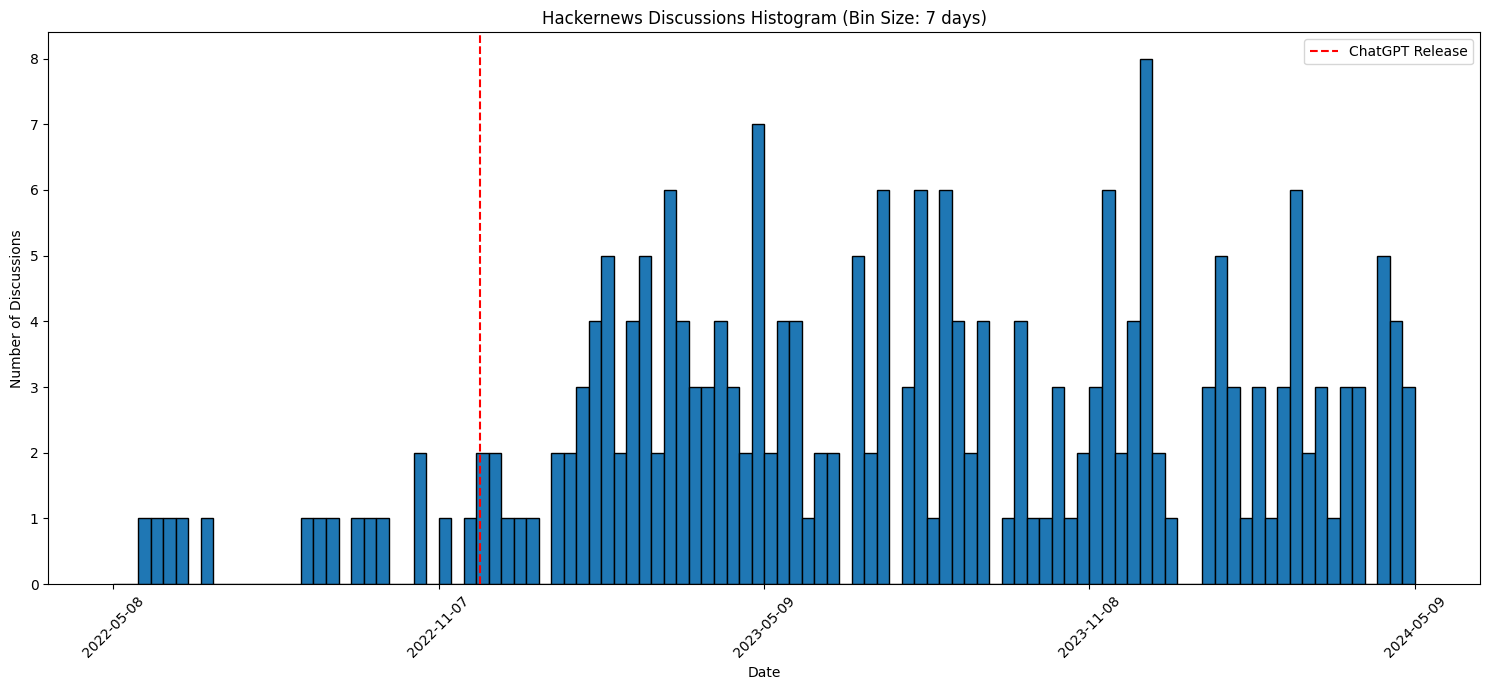

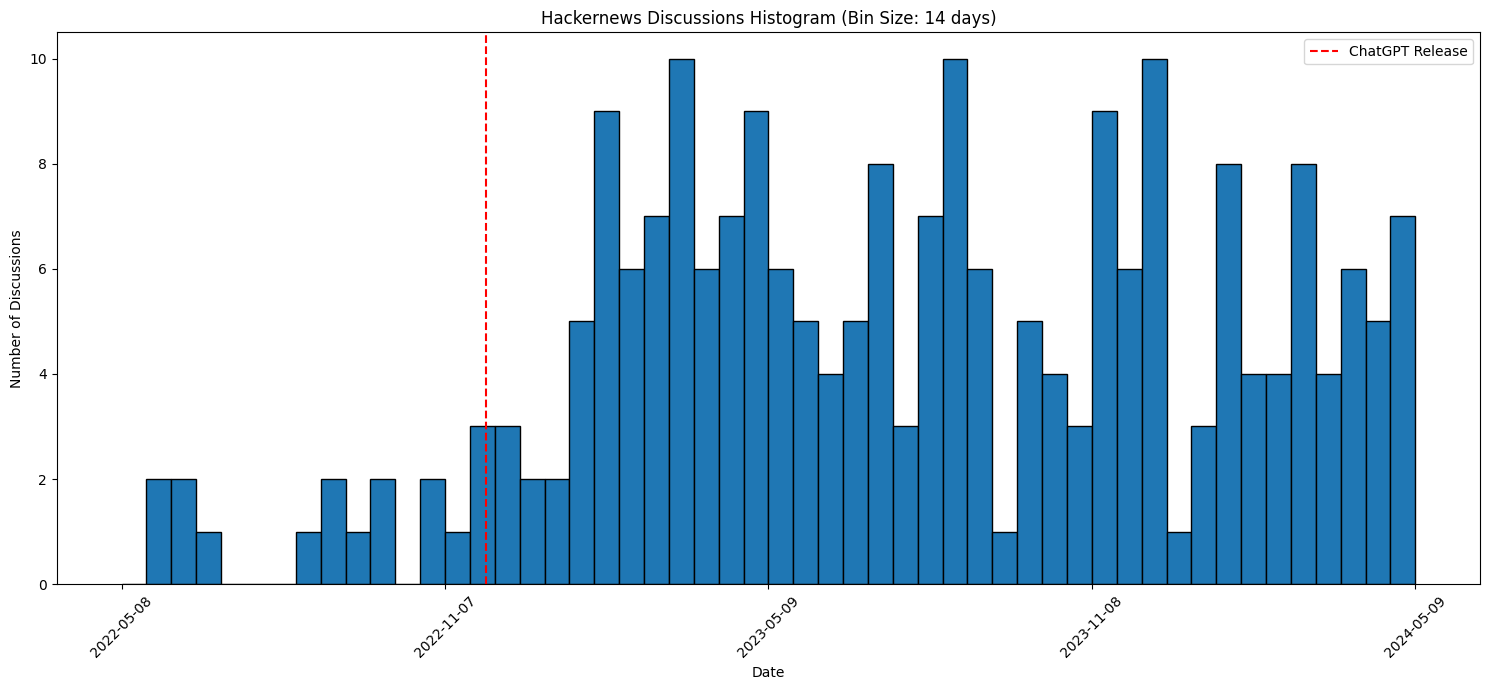

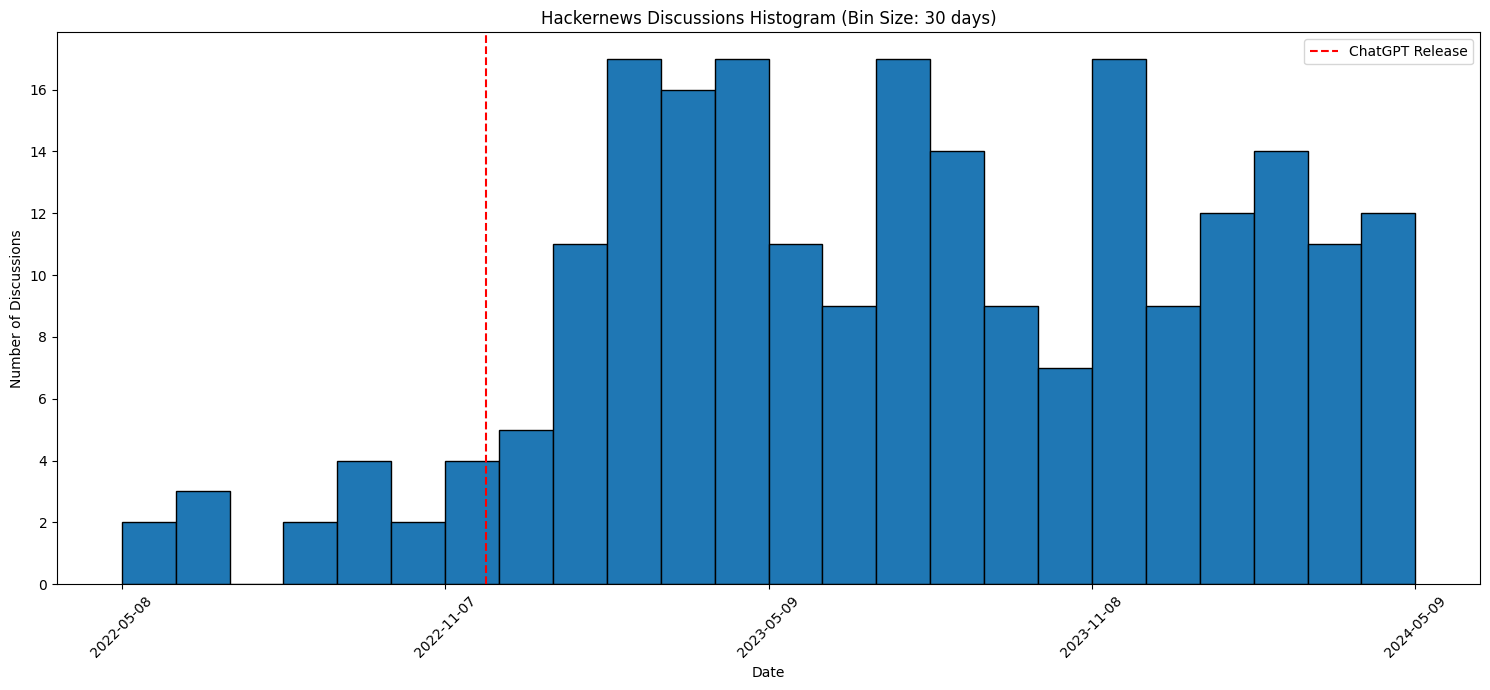

In [23]:
# Example usage
csv_file_path = './dataset_raw.csv'
plot_discussions_histogram(csv_file_path, bin_size_days=7)
plot_discussions_histogram(csv_file_path, bin_size_days=14)
plot_discussions_histogram(csv_file_path, bin_size_days=30)

## graphing by keywords

In [12]:
import re

def plot_discussions_histogram_keywords(csv_file_path, keyword):
    """
    Plot histograms of AI discussions over time from a CSV file with three different bin sizes.

    Args:
    csv_file_path (str): The path to the CSV file.
    keyword (str): The keyword to search for in the title column.
    """
    # Read the CSV file
    df = pd.read_csv(csv_file_path)

    # Filter the dataframe based on the keyword
    df = df[df['title'].str.contains(keyword, case=False, regex=True)]

    # Calculate bin edges from May 2022 to May 2024
    start_date = pd.Timestamp('2022-05-08').timestamp()
    end_date = pd.Timestamp('2024-05-09').timestamp()

    # Create the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 21))

    bin_sizes = [7, 14, 30]
    axes = [ax1, ax2, ax3]

    for ax, bin_size_days in zip(axes, bin_sizes):
        # Calculate number of bins
        total_days = (end_date - start_date) / (24*60*60)
        bins = int(total_days / bin_size_days)

        # Create the histogram
        n, bins, patches = ax.hist(df['date'], bins=bins, range=(start_date, end_date), edgecolor='black')

        # Format x-axis ticks as dates
        def timestamp_to_date(timestamp):
            return datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')

        num_ticks = 5
        tick_locations = np.linspace(start_date, end_date, num_ticks)
        ax.set_xticks(tick_locations)
        ax.set_xticklabels([timestamp_to_date(t) for t in tick_locations])

        ax.set_title(f'Bin Size: {bin_size_days} days')
        ax.set_xlabel('Date')
        ax.set_ylabel('Number of Discussions')
        ax.tick_params(axis='x', rotation=45)

        # Add vertical line for ChatGPT release
        chatgpt_release = pd.Timestamp('2022-11-30').timestamp()
        ax.axvline(x=chatgpt_release, color='r', linestyle='--', label='ChatGPT Release')
        ax.legend()

    plt.suptitle(f'Hackernews Discussions Histograms for Keyword: {keyword}', fontsize=16, y=1.005)
    plt.tight_layout()
    plt.savefig(f'hackernews_keyword_trends_{keyword}.png')
    plt.show()

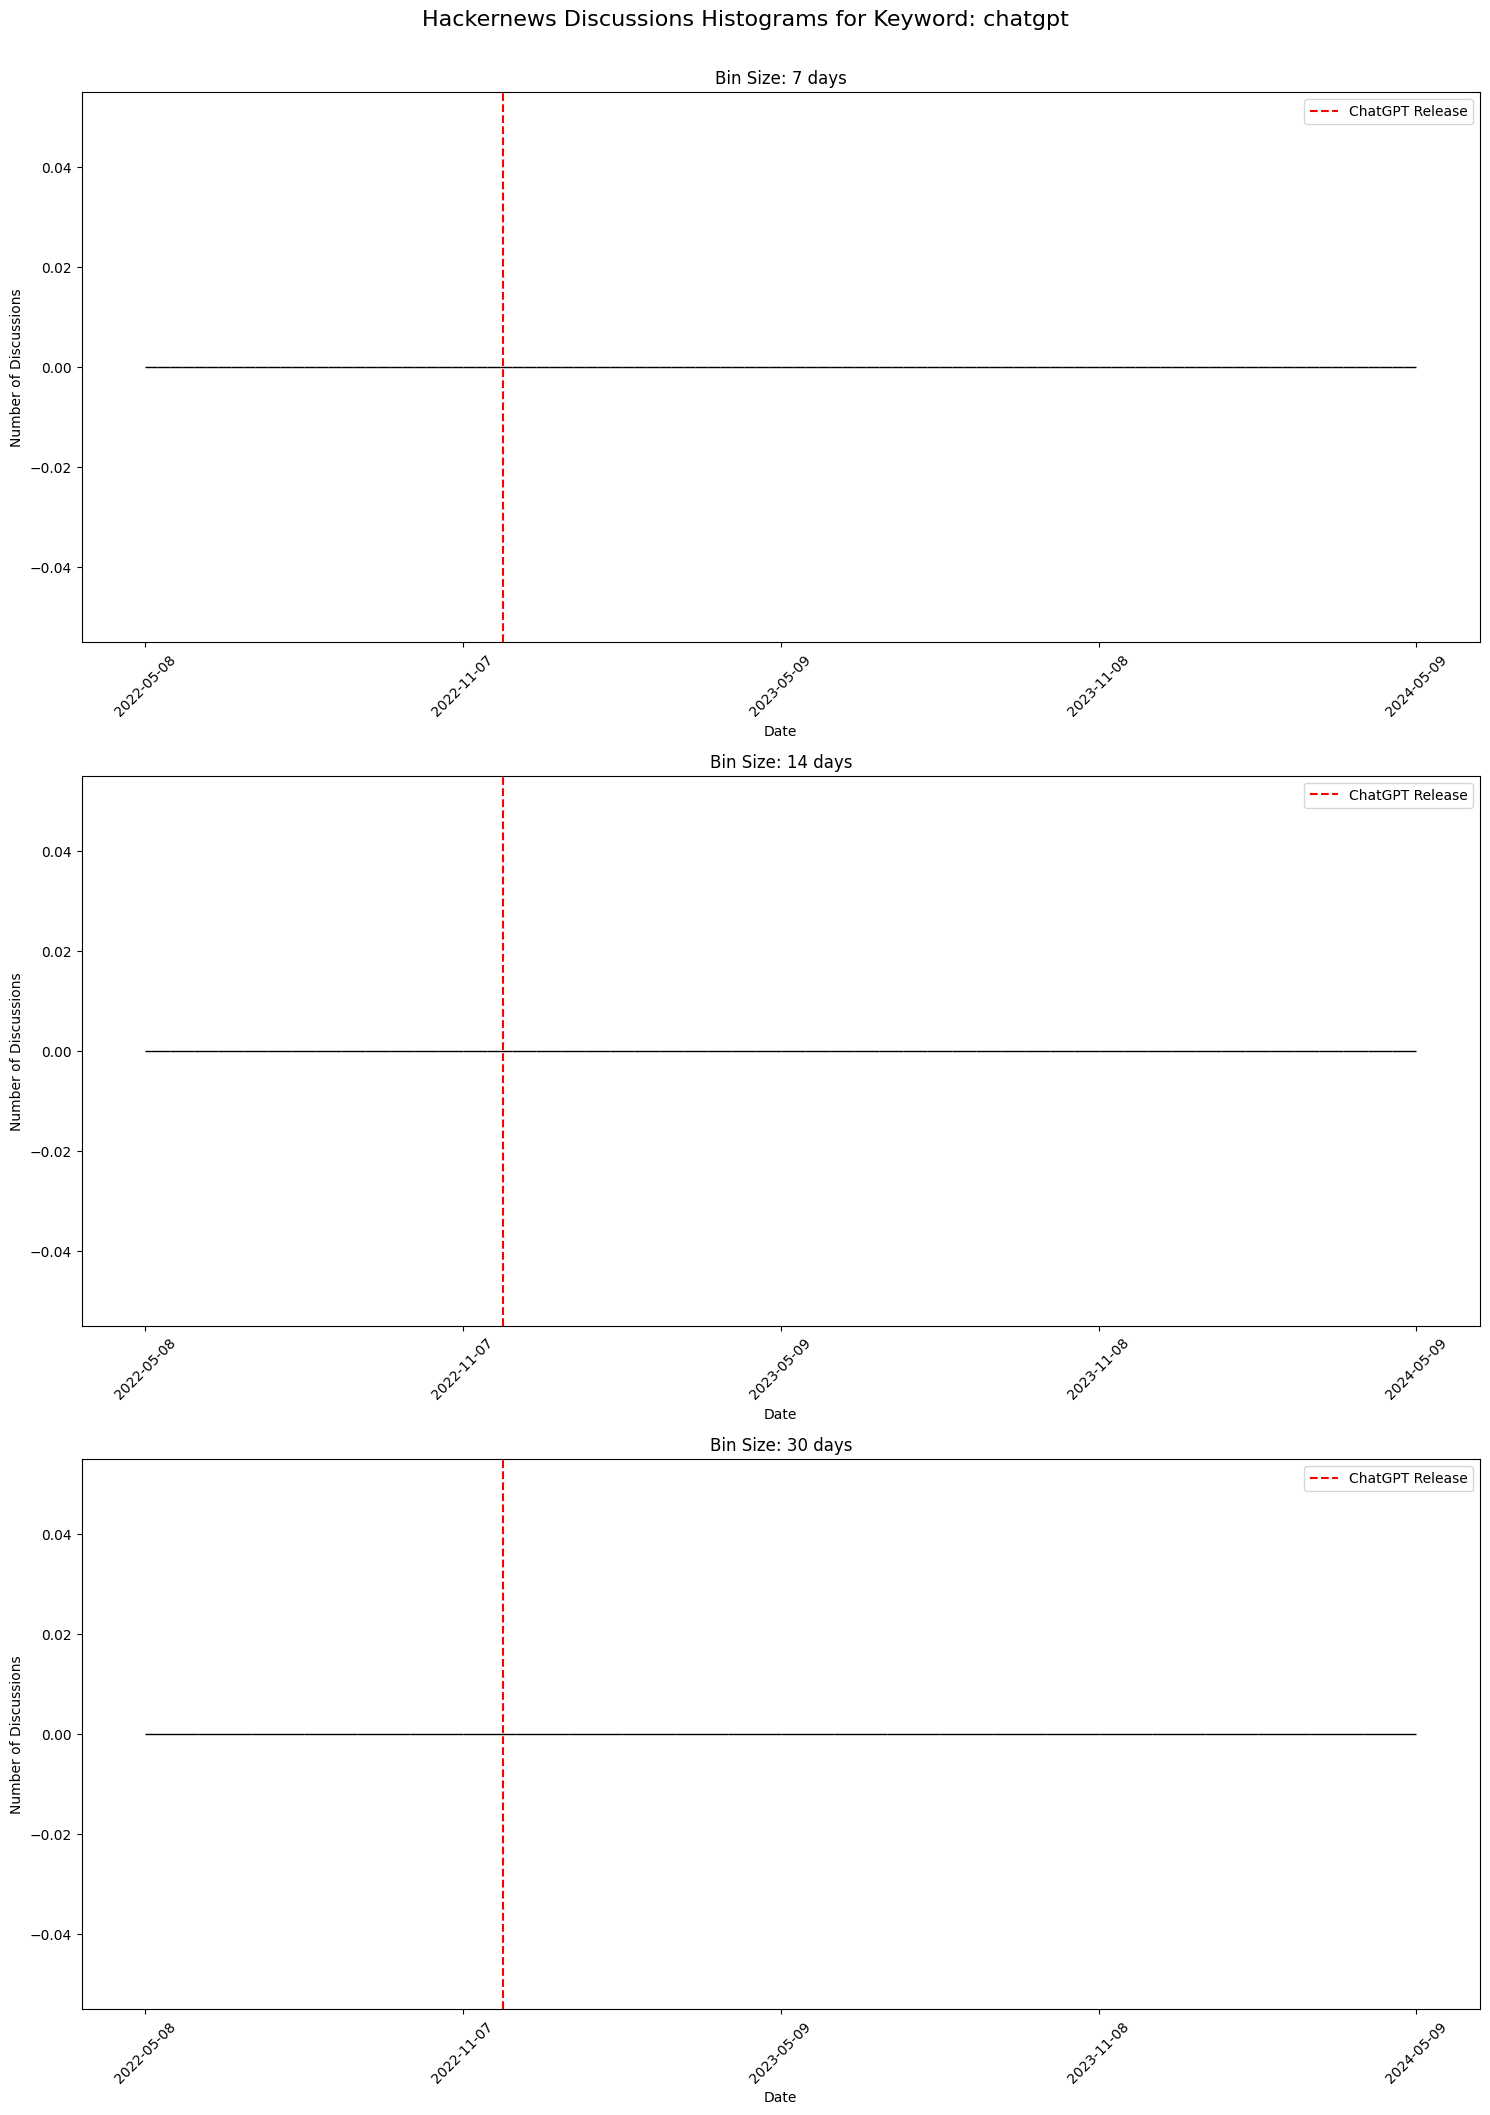

In [13]:
# Example usage
csv_file_path = './dataset_raw.csv'
plot_discussions_histogram_keywords(csv_file_path, keyword='chatgpt')

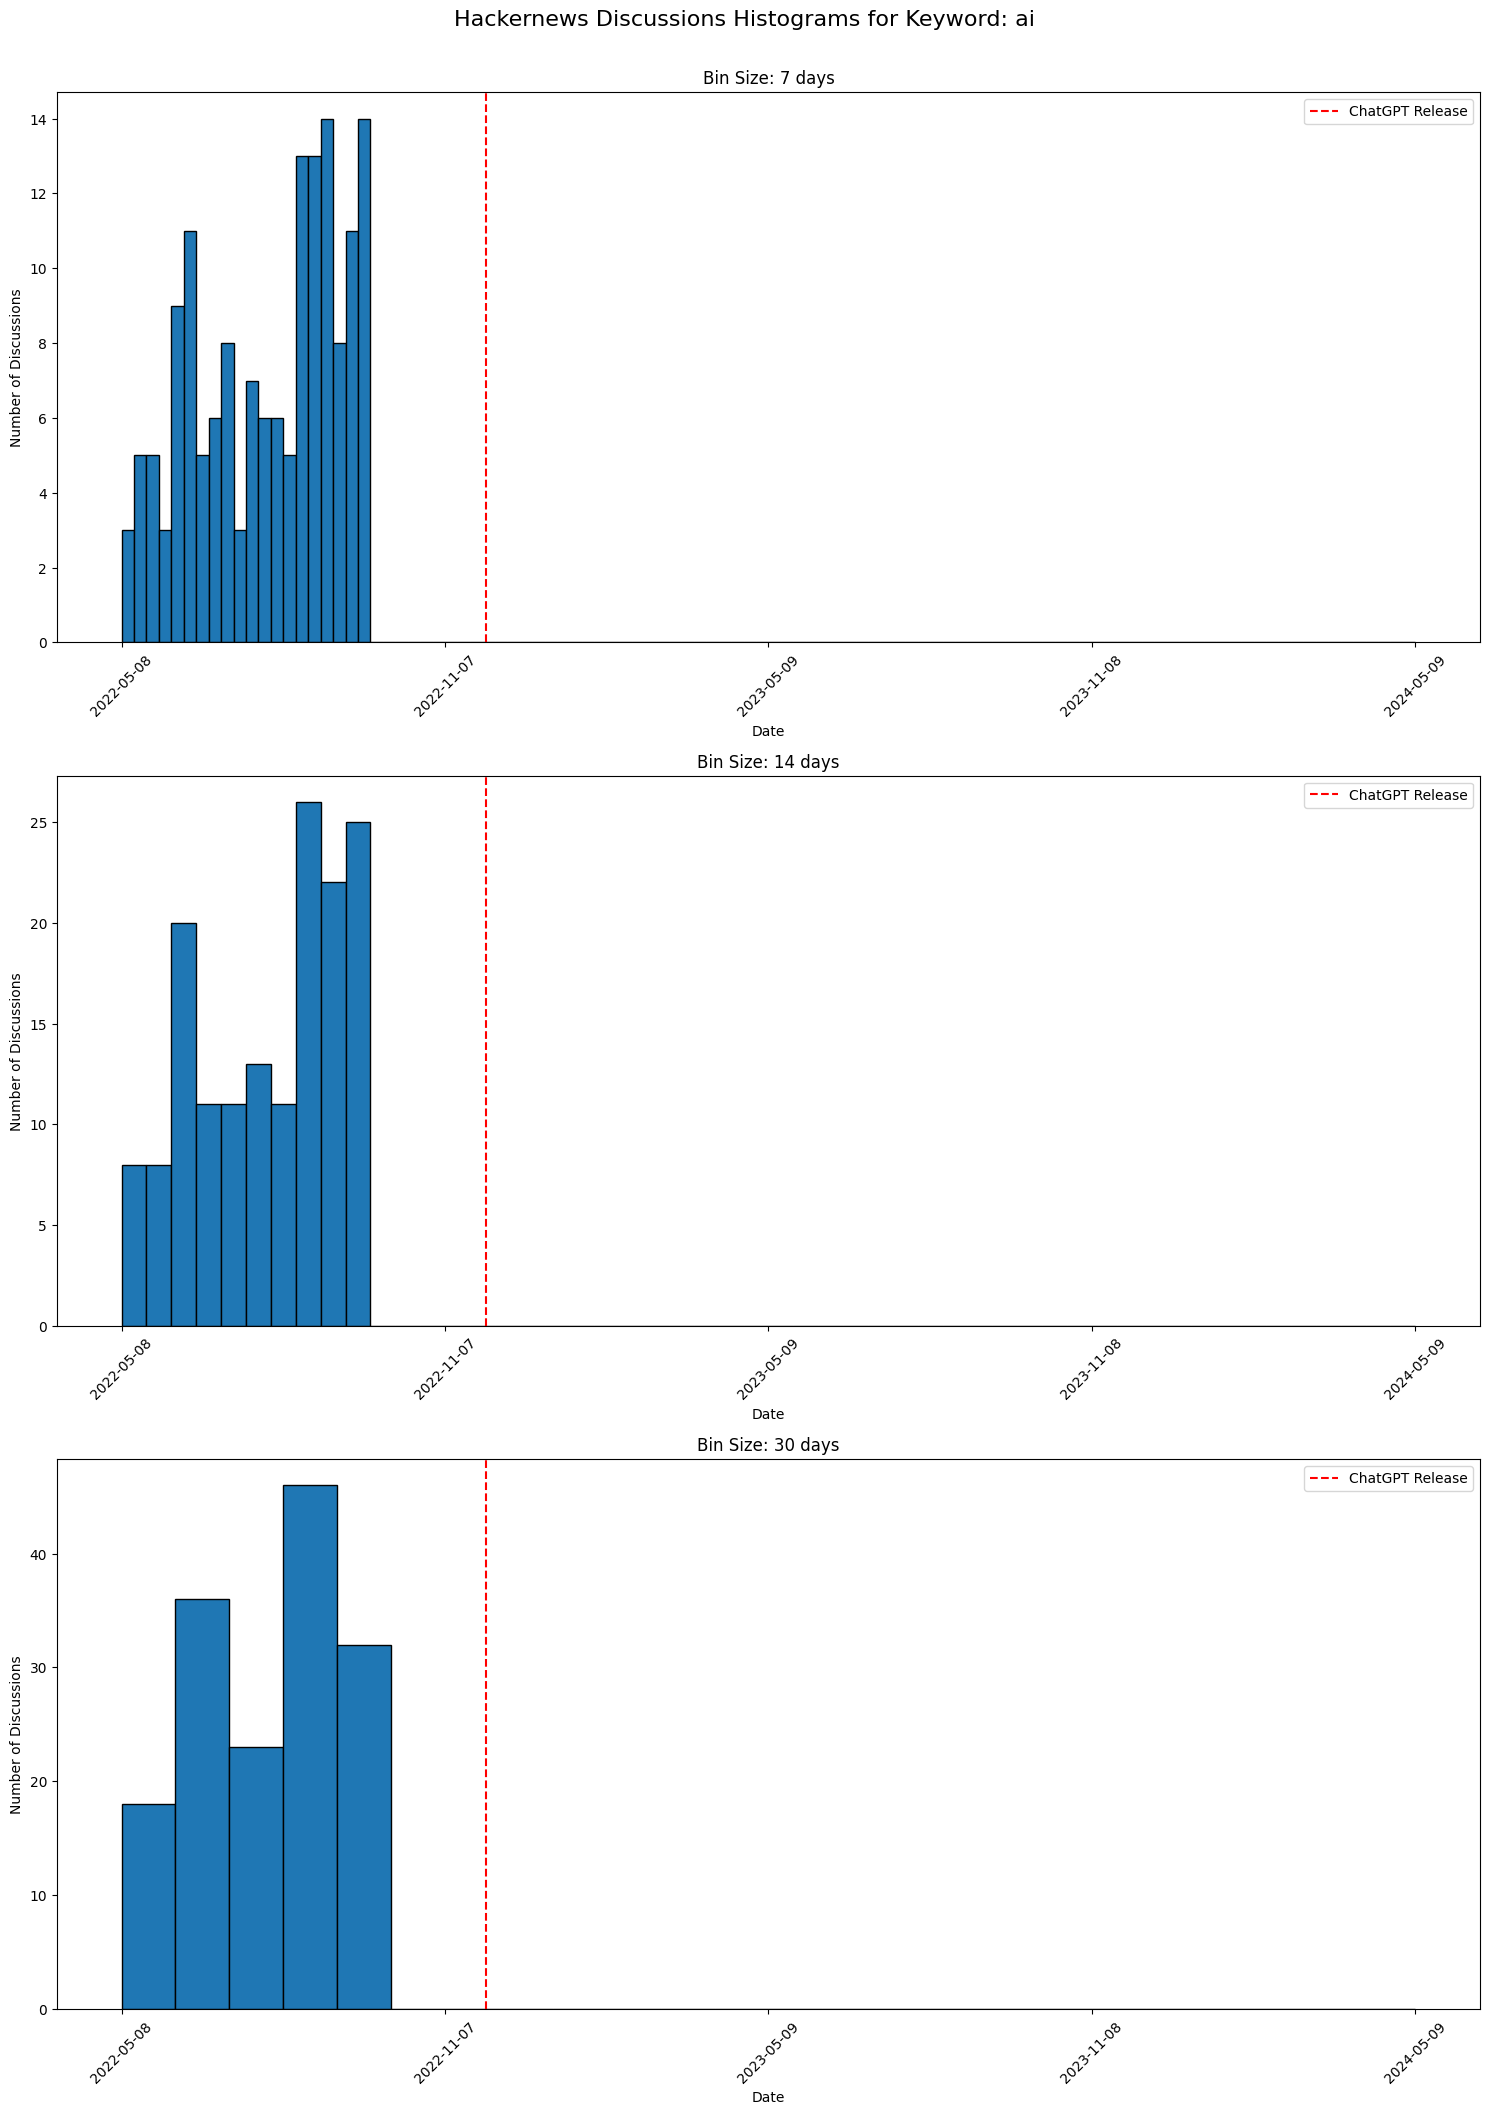

In [14]:

plot_discussions_histogram_keywords(csv_file_path, keyword='ai')

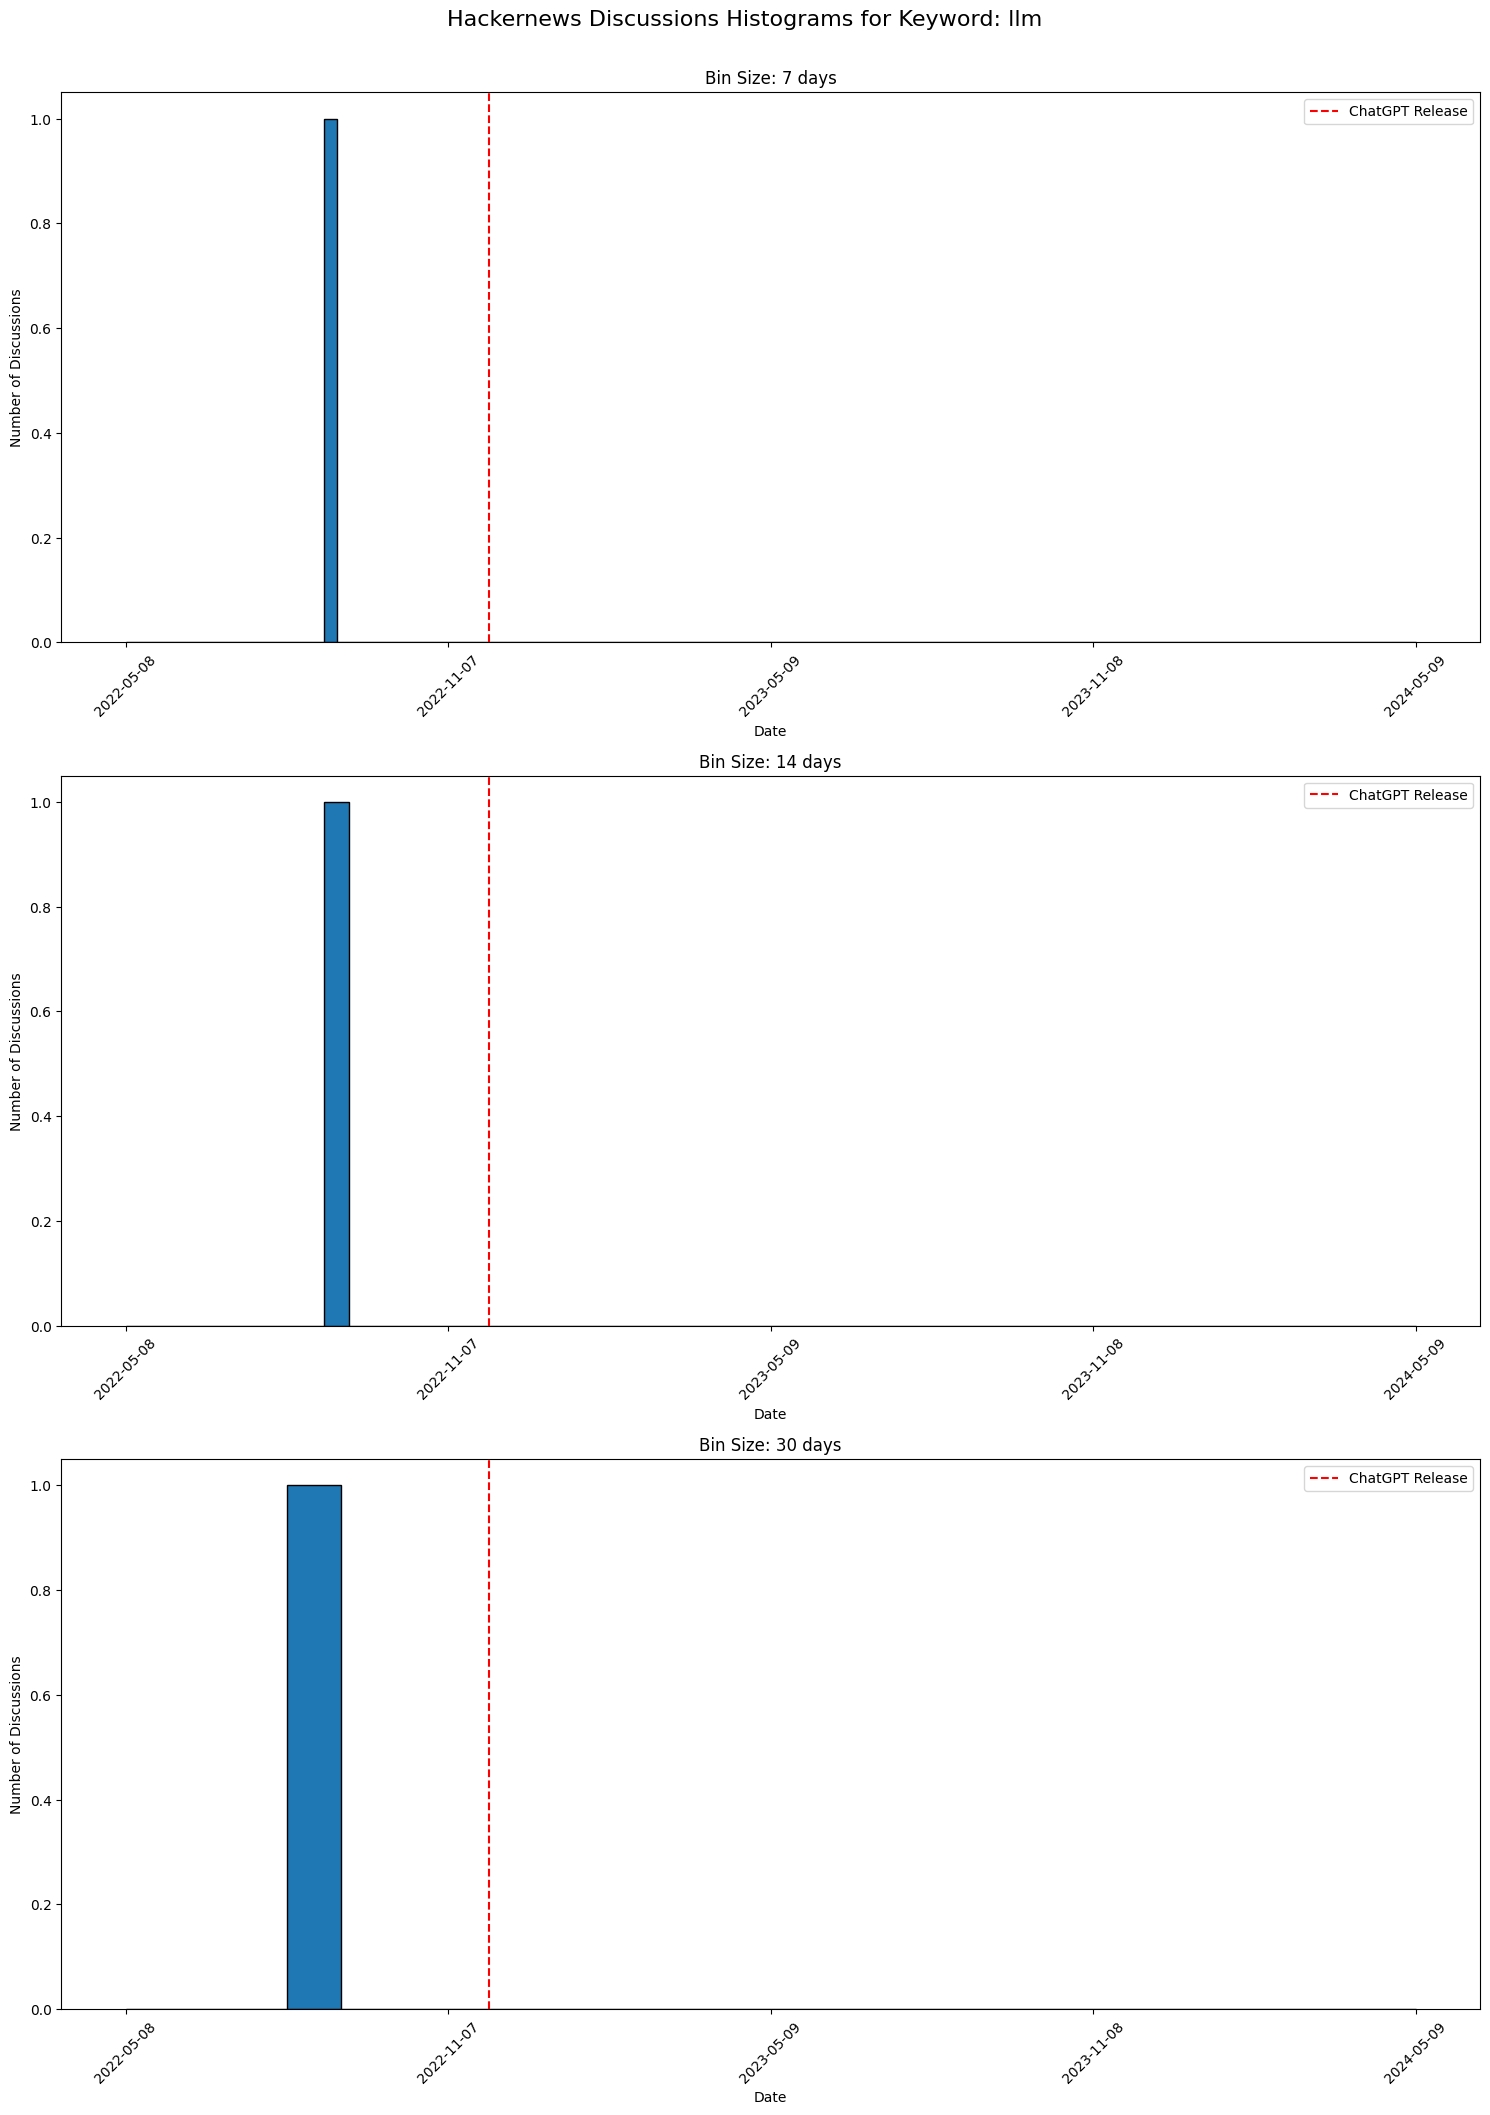

In [15]:

plot_discussions_histogram_keywords(csv_file_path, keyword='llm')

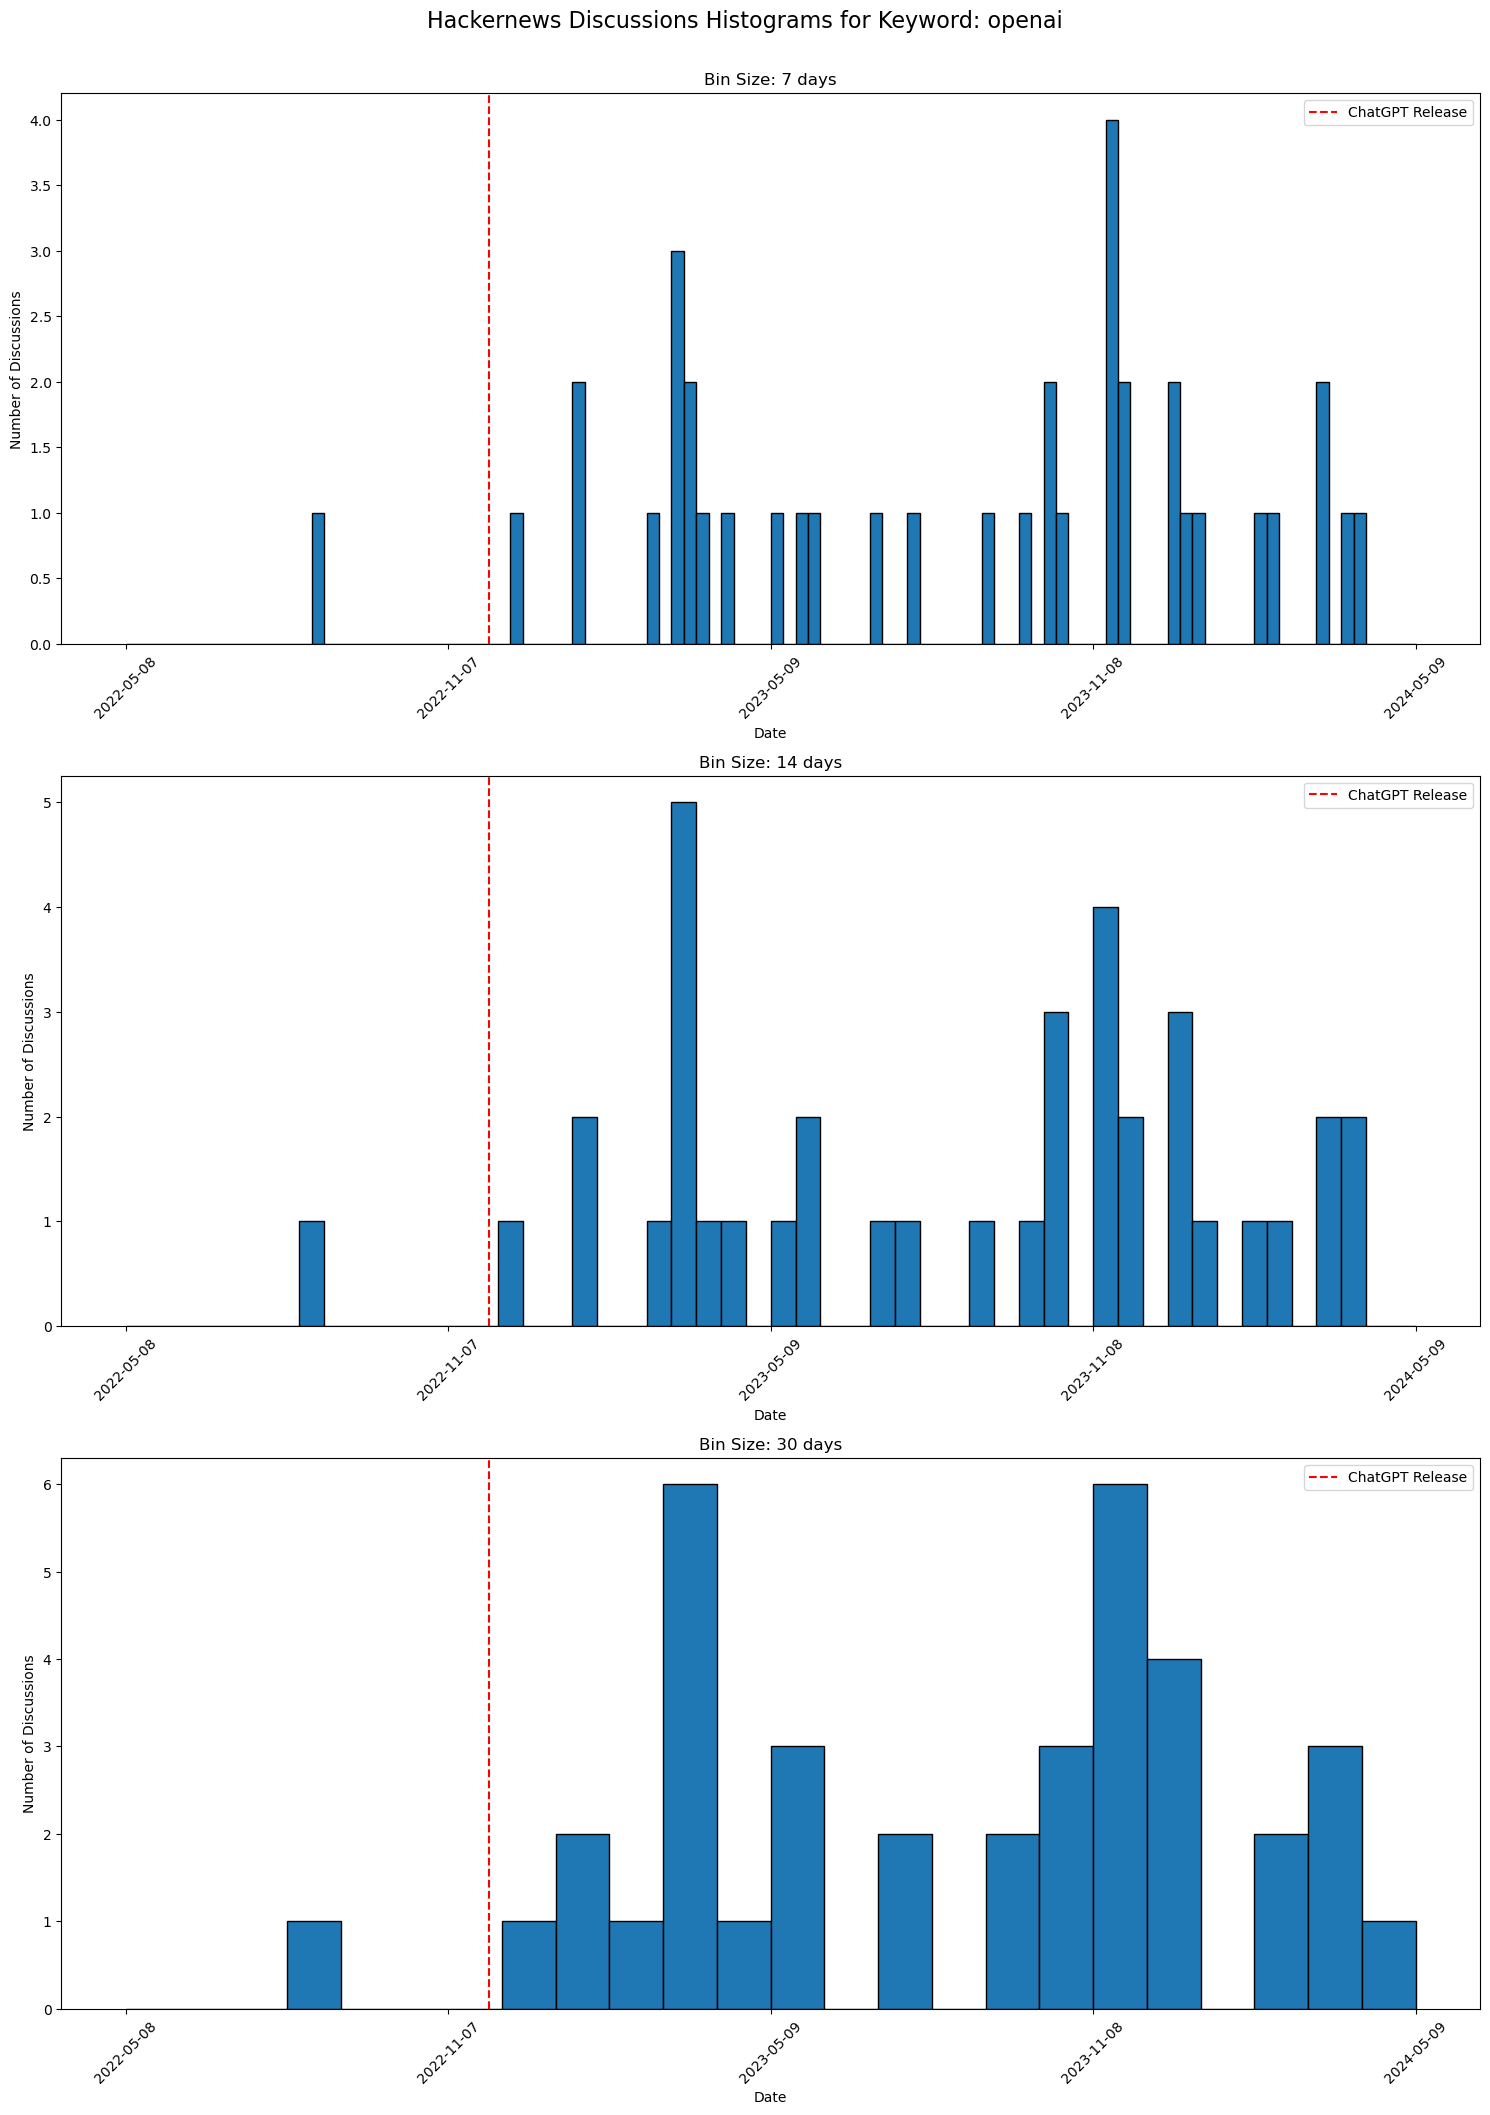

In [ ]:
plot_discussions_histogram_keywords(csv_file_path, keyword='openai')

## time series analysis

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from ruptures import Binseg
import matplotlib.dates as mdates

def perform_rq1_analyses(csv_file_path, keyword):
    # Read and preprocess the data
    df = pd.read_csv(csv_file_path)
    # df = df[df['title'].str.contains(keyword, case=False, regex=True)]
    df['date'] = pd.to_datetime(df['date'], unit='s')
    df = df.sort_values('date')

    # Resample to daily frequency
    daily_counts = df.set_index('date').resample('D').size().fillna(0)

    # 1. Trend Analysis
    # X = np.arange(len(daily_counts)).reshape(-1, 1)
    # y = daily_counts.values
    # linear_model = stats.linregress(X.flatten(), y)
    # print(f"Linear trend: slope={linear_model.slope:.4f}, intercept={linear_model.intercept:.4f}, r-value={linear_model.rvalue:.4f}")

    # 2. Change Point Detection
    # model = Binseg(model="l2").fit(y)
    # change_points = model.predict(n_bkps=3)
    # print(f"Detected change points: {daily_counts.index[change_points]}")

    # 3. Moving Average
    window_size = 30
    moving_avg = daily_counts.rolling(window=window_size).mean()

    # 4. Seasonality Analysis
    # Only perform if we have enough data points
    # if len(daily_counts) > 2 * 365:  # At least 2 years of data
    # result = seasonal_decompose(daily_counts, model='additive', period=350)
    # seasonal_component = result.seasonal
    # else:
    #     seasonal_component = None
    #     print("Not enough data for seasonal decomposition")

    # 5. Impact of ChatGPT Release
    chatgpt_release = pd.Timestamp('2022-11-30')
    before_chatgpt = daily_counts[daily_counts.index < chatgpt_release]
    after_chatgpt = daily_counts[daily_counts.index >= chatgpt_release]
    t_stat, p_value = stats.ttest_ind(before_chatgpt, after_chatgpt)
    print(f"T-test results: t-statistic={t_stat:.4f}, p-value={p_value:.4f}")

    # 6. Correlation with Time
    time_values = np.arange(len(daily_counts))
    correlation = np.corrcoef(time_values, daily_counts.values)[0, 1]
    print(f"Correlation with time: {correlation:.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(30, 15))

    # Original data with trend and moving average
    ax1.plot(daily_counts.index, daily_counts.values, label='Daily Counts')
    # ax1.plot(daily_counts.index, linear_model.slope * X.flatten() + linear_model.intercept, 'r', label='Linear Trend')
    ax1.plot(daily_counts.index, moving_avg, 'g', label=f'{window_size}-day Moving Average')
    # for cp in change_points:
    #     ax1.axvline(daily_counts.index[cp], color='purple', linestyle='--')
    ax1.axvline(chatgpt_release, color='orange', linestyle='--', label='ChatGPT Release')
    ax1.set_title('AI/LLM Discussions on Hackernews Over Time')
    ax1.legend()
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Seasonal decomposition
    # if seasonal_component is not None:
    #     ax2.plot(seasonal_component)
    #     ax2.set_title('Seasonal Component')
    #     ax2.xaxis.set_major_locator(mdates.MonthLocator())
    #     ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    #     plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    # else:
    #     ax2.text(0.5, 0.5, 'Not enough data for seasonal decomposition',
    #              horizontalalignment='center', verticalalignment='center')

    plt.tight_layout()
    plt.show()


T-test results: t-statistic=-9.3618, p-value=0.0000
Correlation with time: 0.2604


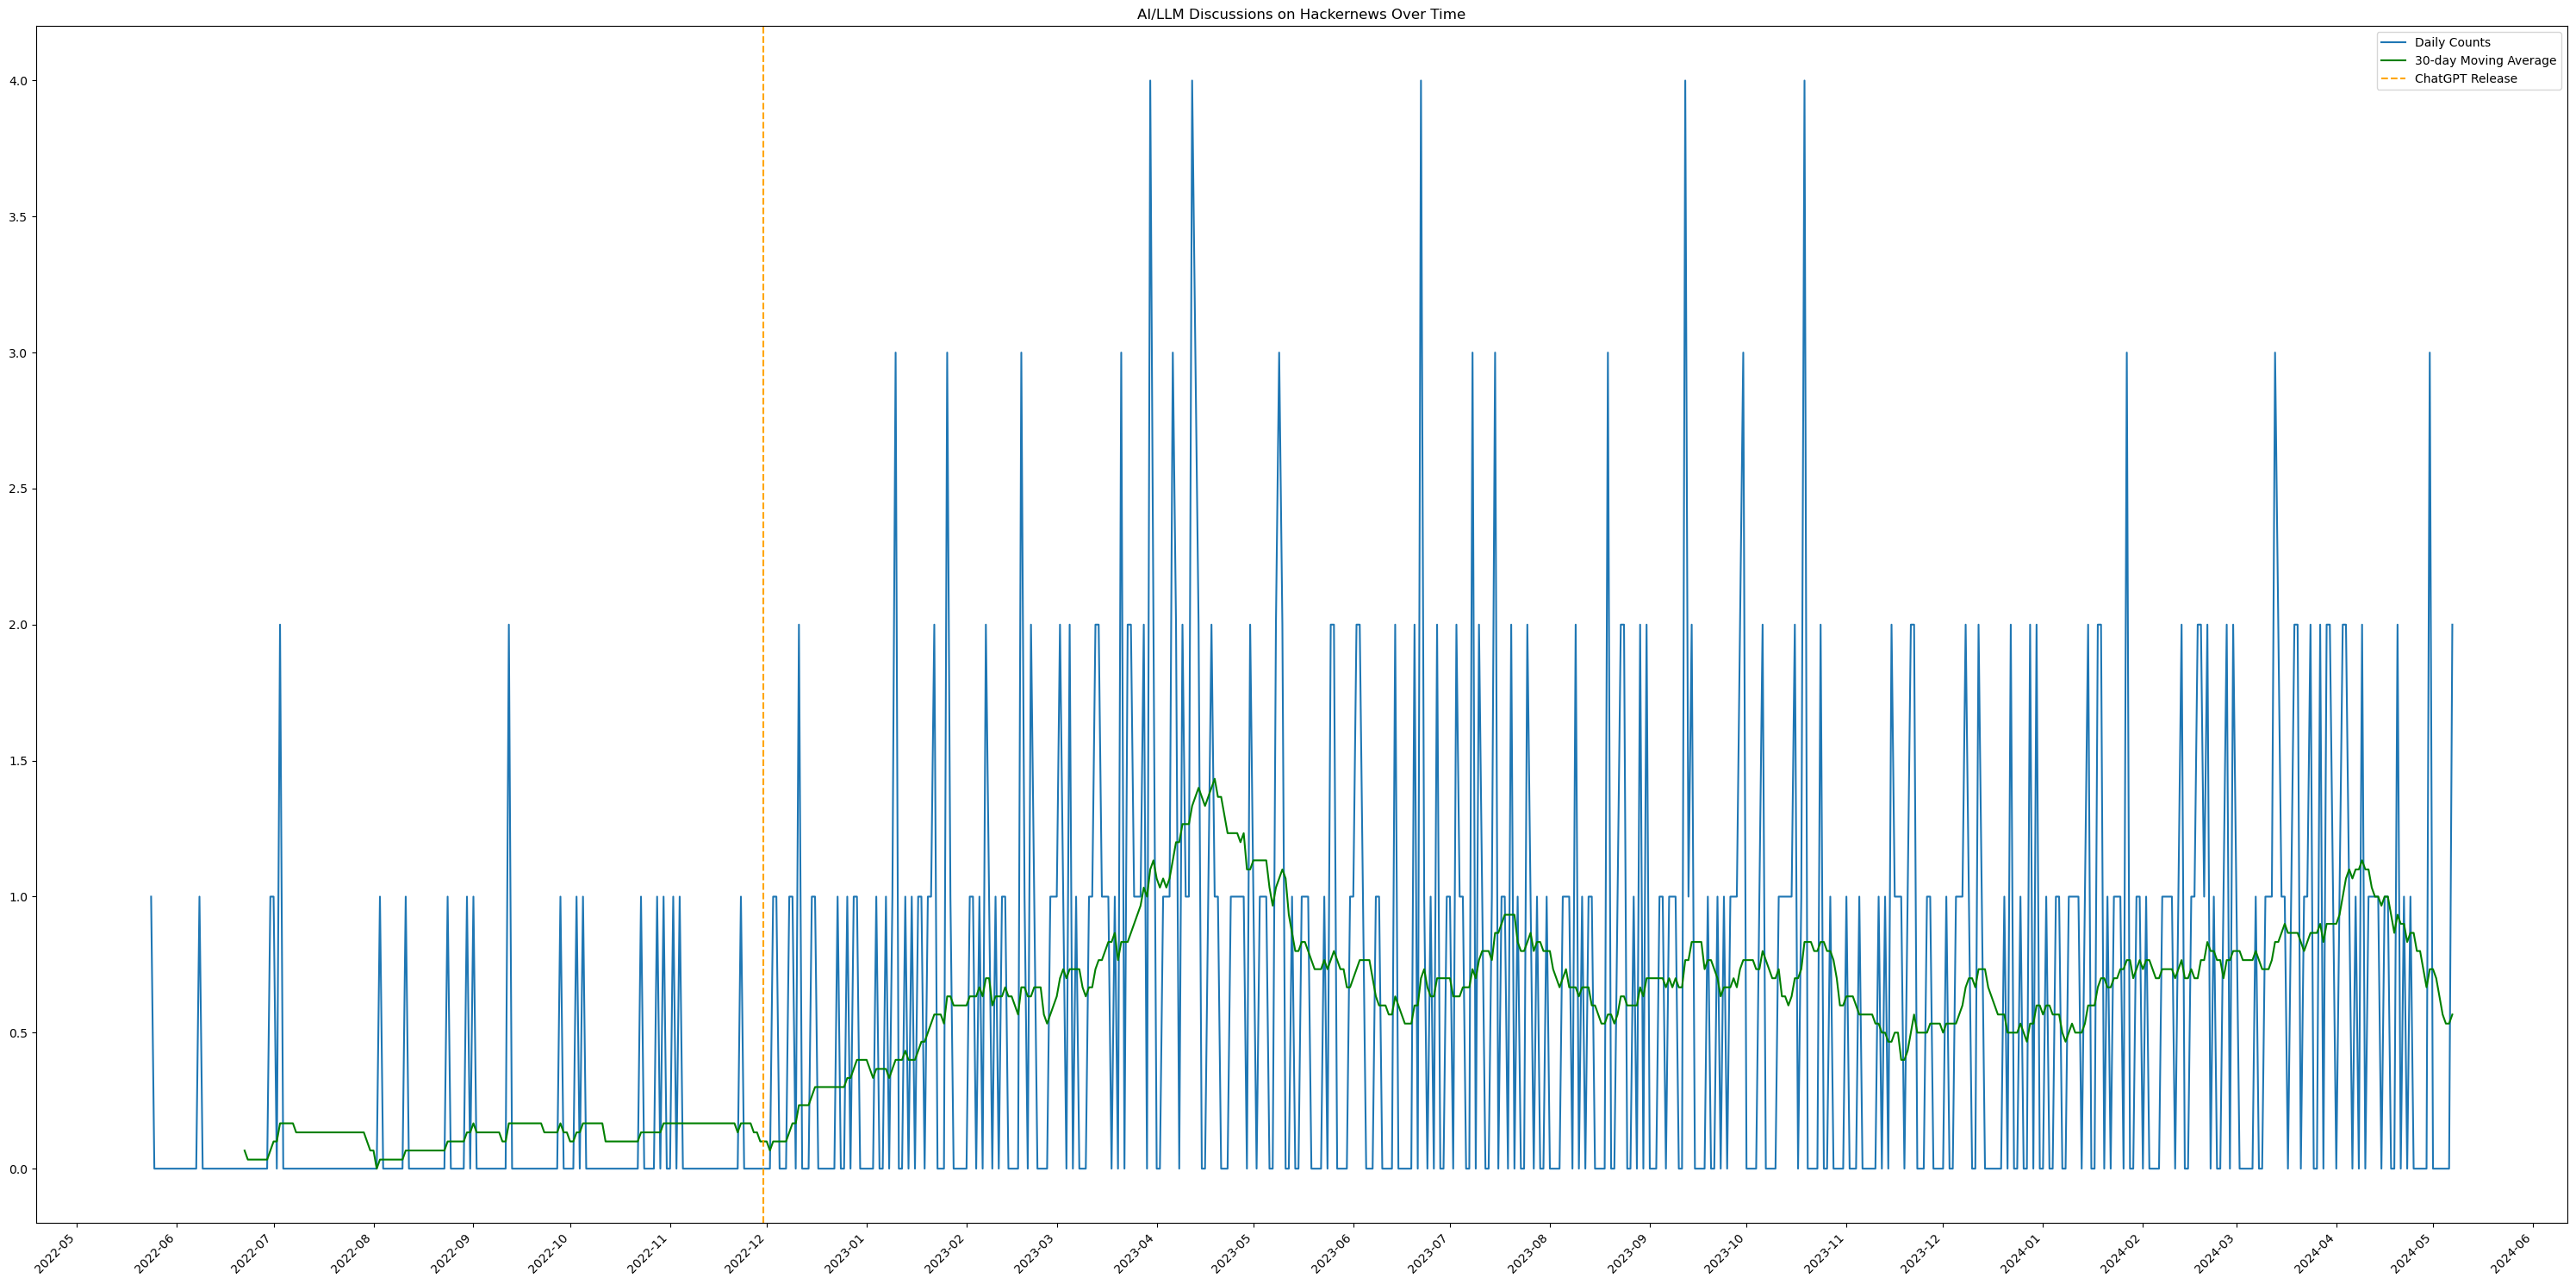

In [ ]:
csv_file_path = './dataset_raw.csv'
keyword = 'ai'
perform_rq1_analyses(csv_file_path=csv_file_path, keyword=keyword)